## Collect

Na EximiaCo, acreditamos que o "código" é a principal fonte da verdade. Por isso, valorizamos dados extraídos do código fonte.

Nesse exercício, coletamos informações com relação ao volume de modificações (changes) dos arquivos de um repositório GIT na máquina local. 

Consideramos os últimos três meses de modificações porque entendemos que essa é uma janela relevante para mostrar o "momento do time"

In [4]:
import os.path
! pip install GitPython --quiet

In [9]:
import sys
sys.path.append('../src')

In [10]:
from localgit import LocalGit
from weeks import Weeks

In [11]:
start, _ = Weeks.get_previous(12)
_, end = Weeks.get_current()

git = LocalGit("~/Documents/GitHub/ravendb")
commits = git.get_commits("v6.0", start, end)

In [12]:
len(commits)

4527

In [13]:
commits

,sha,author,file,changes,insertions,deletions,bytes,lines
0,99fe8133164d9d09f0f7f66891d890ab3c0d5b9e,Arkadiusz Palinski,test/SlowTests/Sharding/Backup/ShardedBackupTe...,9,6,3,38460,859
1,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Raven.Server/Documents/Indexes/MapReduce/M...,7,5,2,15707,364
2,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.MultiTree.cs,7,5,2,16090,393
3,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.Stream.cs,7,5,2,19466,595
4,5a0c275b4e88f92c9f6c24181e4e3c7cc79680aa,Arkadiusz Palinski,src/Voron/Data/BTrees/Tree.cs,2,1,1,61978,1710
...,...,...,...,...,...,...,...,...
4522,018b5a83d9fd8f94d41544ba8d30caa7fcf1370c,egor,test/StressTests/Issues/RavenDB_18420.cs,6,5,1,4800,96
4523,9511f936a2665e56443bf58682eed493052f0869,egor,src/Raven.Server/Documents/DatabasesLandlord.cs,21,16,5,59213,1301
4524,9511f936a2665e56443bf58682eed493052f0869,egor,src/Raven.Server/Web/System/OngoingTasksHandle...,7,4,3,87472,1710
4525,9511f936a2665e56443bf58682eed493052f0869,egor,test/SlowTests/Issues/RavenDB-18442.cs,6,1,5,4895,129


## Organize

In [14]:
from ravendb_git import RavenDB_git

start, _ = Weeks.get_previous(12)
_, end = Weeks.get_current()

ravendb = RavenDB_git("~/Documents/GitHub/ravendb")
commits = ravendb.get_commits("v6.0", start, end)

In [15]:
commits.get_summary_by_file().head(10)

,file,changes,perc
1405,test/SlowTests/Server/Documents/PeriodicBackup...,3569,3.432490
858,src/Raven.Studio/typescript/components/pages/r...,2718,2.614040
840,src/Raven.Studio/typescript/components/pages/r...,2619,2.518826
1071,src/Sparrow/Memory.cs,1816,1.746540
1188,test/SlowTests/Client/Subscriptions/Concurrent...,1695,1.630168
649,src/Raven.Studio/typescript/components/common/...,1605,1.543611
844,src/Raven.Studio/typescript/components/pages/r...,1432,1.377228
313,src/Raven.Server/Documents/Queries/CollectionQ...,1110,1.067544
1046,src/Sparrow.Server/AdvMemory.cs,1002,0.963675
1334,test/SlowTests/Issues/RavenDB_22110.cs,960,0.923281


In [16]:
commits.get_summary_by_author()

,author,changes,perc
0,Arkadiusz Paliński,38005,36.551353
2,Damian Olszewski,34071,32.767824
3,Federico Lois,6497,6.248497
10,Maciej Aszyk,3355,3.226675
15,Paweł Pekról,2858,2.748685
24,shiranshalom,2582,2.483241
14,Michał Leśniak,2568,2.469777
8,Karmel Indych,2237,2.151437
20,efrat@ravendb.net,2110,2.029295
21,egor,2019,1.941776


In [17]:
commits.get_summary_by('root')

,root,changes,perc
4,src,76863,73.927345
5,test,25690,24.708813
6,tools,1010,0.971425
1,bench,308,0.296236
0,.github,62,0.059632
3,scripts,32,0.030778
2,docker,6,0.005771


In [18]:
commits.get_summary_by('code_project')

,code_project,changes,perc
15,Raven.Studio,45637,43.925234
18,SlowTests,19781,19.039048
14,Raven.Server,14772,14.217927
10,Raven.Client,6019,5.793238
28,Voron,3694,3.555444
19,Sparrow,2712,2.610277
20,Sparrow.Server,2433,2.341742
4,FastTests,2240,2.155981
24,Tests.Infrastructure,2058,1.980808
2,Corax,1505,1.448550


## Distill

Concluída a organização, é hora de começar a explorar os dados para, com base na experiência, coletar alguns insights.

In [19]:
! pip install matplotlib seaborn --quiet

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


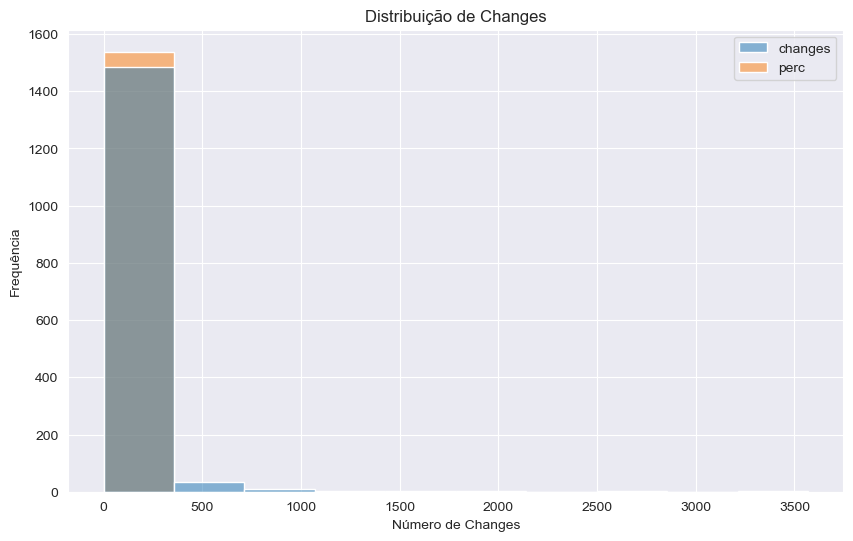

In [21]:
plt.figure(figsize=(10, 6))
sns.histplot(commits.get_summary_by_file(), bins=10, kde=False)
plt.title('Distribuição de Changes')
plt.xlabel('Número de Changes')
plt.ylabel('Frequência')
plt.show()

In [22]:
! pip install numpy --quiet

In [23]:
commits.get_histogram_by('file')

,Bin Min,Bin Max,Frequency
0,0.0,356.9,1484
1,356.9,713.8,35
2,713.8,1070.7,11
3,1070.7,1427.6,1
4,1427.6,1784.5,3
5,1784.5,2141.4,1
6,2141.4,2498.3,0
7,2498.3,2855.2,2
8,2855.2,3212.1,0
9,3212.1,3569.0,1


In [24]:
def get_files(bin_min, bin_max):
    result = commits.get_summary_by_file()
    return commits.get_summary_by_file()[ 
        (result['changes'] >= bin_min) & 
        (result['changes'] <= bin_max)
    ].copy()

In [25]:
most_modified_files = get_files(1104, 3681)
most_modified_files

,file,changes,perc
1405,test/SlowTests/Server/Documents/PeriodicBackup...,3569,3.432490
858,src/Raven.Studio/typescript/components/pages/r...,2718,2.614040
840,src/Raven.Studio/typescript/components/pages/r...,2619,2.518826
1071,src/Sparrow/Memory.cs,1816,1.746540
1188,test/SlowTests/Client/Subscriptions/Concurrent...,1695,1.630168
649,src/Raven.Studio/typescript/components/common/...,1605,1.543611
844,src/Raven.Studio/typescript/components/pages/r...,1432,1.377228
313,src/Raven.Server/Documents/Queries/CollectionQ...,1110,1.067544


In [26]:
most_modified_files['changes'].sum()

16564

In [27]:
most_modified_files['perc'].sum()

15.930446156361503

In [28]:
list(most_modified_files['file'])

['test/SlowTests/Server/Documents/PeriodicBackup/PeriodicBackupSlowTests.cs',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/regular/CreateDatabaseRegular.tsx',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/formBackup/CreateDatabaseFromBackup.tsx',
 'src/Sparrow/Memory.cs',
 'test/SlowTests/Client/Subscriptions/ConcurrentSubscriptionsTests.cs',
 'src/Raven.Studio/typescript/components/common/CreateDatabase.tsx',
 'src/Raven.Studio/typescript/components/pages/resources/databases/partials/create/formBackup/steps/CreateDatabaseFromBackupStepSource.tsx',
 'src/Raven.Server/Documents/Queries/CollectionQueryEnumerable.cs']

In [29]:
len(most_modified_files) / len(commits.get_summary_by_file()) * 100

0.5201560468140443

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


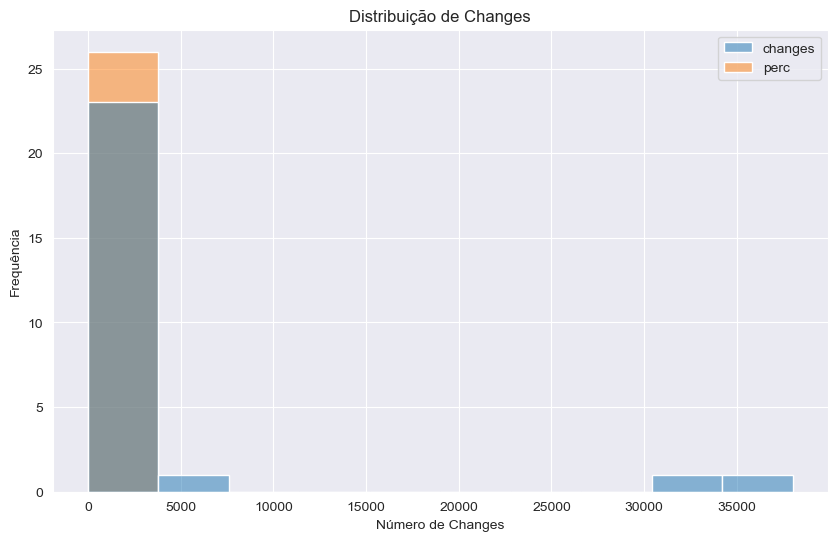

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(commits.get_summary_by_author(), bins=10, kde=False)
plt.title('Distribuição de Changes')
plt.xlabel('Número de Changes')
plt.ylabel('Frequência')
plt.show()

In [32]:
commits.get_histogram_by('author')

,Bin Min,Bin Max,Frequency
0,14.0,3813.1,23
1,3813.1,7612.2,1
2,7612.2,11411.3,0
3,11411.3,15210.4,0
4,15210.4,19009.5,0
5,19009.5,22808.6,0
6,22808.6,26607.7,0
7,26607.7,30406.8,0
8,30406.8,34205.9,1
9,34205.9,38005.0,1


In [4]:
commits.get_projects_of_author('Arkadiusz Paliński')

,code_project,changes,perc
18,SlowTests,11795,31.081188
15,Raven.Studio,9375,24.704208
14,Raven.Server,6018,15.858125
10,Raven.Client,1919,5.056787
19,Sparrow,1478,3.894701
20,Sparrow.Server,1277,3.365043
2,Corax,1266,3.336056
4,FastTests,1022,2.693088
28,Voron,878,2.313631
24,Tests.Infrastructure,865,2.279375


In [5]:
commits.get_projects_of_author('Damian Olszewski')

,code_project,changes,perc
1,Raven.Studio,34064,99.979455
0,Raven.Server,7,0.020545


In [6]:
commits.get_projects_of_author('Paweł Pekról')

,code_project,changes,perc
18,SlowTests,701,24.527642
10,Raven.Client,594,20.783765
14,Raven.Server,451,15.780266
23,Tests.Infrastructure,379,13.261022
13,Raven.Migrator,78,2.729181
4,FastTests,53,1.854444
0,BenchmarkTests,40,1.399580
20,StressTests,38,1.329601
31,rvn,36,1.259622
32,workflows,32,1.119664


In [5]:
commits.get_authors_of_project('Voron')

,author,changes,perc
1,Federico Lois,2698,73.037358
0,Arkadiusz Paliński,878,23.768273
6,egor,67,1.813752
4,Maciej Aszyk,21,0.568489
5,Paweł Pekról,16,0.433135
2,Grisha Kotler,13,0.351922
3,Karmel Indych,1,0.027071


In [6]:
commits.get_authors_of_project('Raven.Server')

,author,changes,perc
0,Arkadiusz Paliński,6018,40.739236
15,shiranshalom,1130,7.649607
6,Karmel Indych,1122,7.595451
2,Federico Lois,1030,6.972651
12,efrat@ravendb.net,1015,6.871108
7,Lev Skuditsky,928,6.282155
8,Maciej Aszyk,755,5.111021
9,Michał Leśniak,744,5.036556
14,shaharhikri,681,4.610073
3,Grisha Kotler,565,3.824804


In [7]:
commits.get_authors_of_project('Raven.Studio')

,author,changes,perc
1,Damian Olszewski,34064,74.641190
0,Arkadiusz Paliński,9375,20.542542
3,Mateusz Bartosik,1175,2.574665
5,Rafal Kwiatkowski,680,1.490019
2,Marcin Lewandowski,272,0.596008
6,danielle9897,52,0.113943
4,Paweł Pekról,16,0.035059
7,shiranshalom,3,0.006574


In [8]:
commits.get_authors_of_project('Raven.Client')

,author,changes,perc
0,Arkadiusz Paliński,1919,31.882372
6,Michał Leśniak,952,15.816581
4,Maciej Aszyk,910,15.118790
14,shiranshalom,873,14.504070
7,Paweł Pekról,594,9.868749
8,Stav Lagziel,235,3.904303
3,Karmel Indych,187,3.106828
9,aviv,133,2.209669
2,James Thompson,122,2.026915
10,efrat@ravendb.net,35,0.581492
